In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
import torchvision

import datasets
import hier

In [2]:
dataset = torchvision.datasets.ImageNet('/home/jack/data/torchvision/imagenet/', 'train')

In [3]:
with open('resources/hierarchy/imagenet_fiveai.csv') as f:
    tree, names = hier.make_hierarchy_from_edges(hier.load_edges(f))

In [4]:
node_spec = -np.log(tree.num_leaf_descendants() / tree.num_leaf_nodes())

In [5]:
label_order = tree.leaf_subset()

In [6]:
paths = tree.paths()
paths = [paths[i] for i in label_order]

In [7]:
# Simplify paths! Remove nodes that have 1 child.
is_valid = (tree.num_children() != 1)
if not np.all(is_valid):
    len_before = np.mean(list(map(len, paths)))
    paths = [path[is_valid[path]] for path in paths]
    len_after = np.mean(list(map(len, paths)))
    print('exclude trivial nodes, mean len', len_before, '->', len_after)

In [8]:
specs = [node_spec[path] for path in paths]

In [9]:
spec_fracs = [spec / spec[-1] for spec in specs]
out = np.full([len(paths), max(map(len, paths))], np.nan)
for i, x in enumerate(spec_fracs):
    out[i, :len(x)] = x
spec_fracs = out
del out

In [10]:
a, b = 2, 1

rng = np.random.default_rng(0)
# r = rng.beta(a, b, size=[len(dataset)])
u = rng.uniform(size=[len(dataset)])
r = scipy.stats.beta.ppf(u, a, b)

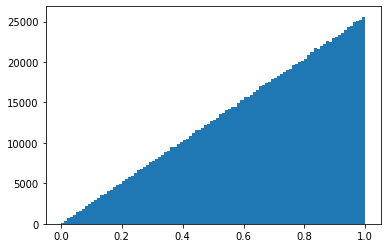

In [11]:
plt.hist(r, range=(0, 1), bins=100);

In [12]:
def first(condition, axis=-1):
    assert np.all(np.any(condition, axis=axis))
    return np.argmax(condition, axis=axis)

In [13]:
# first_ge = np.array([first(spec_fracs[y_i] >= r_i) for y_i, r_i in zip(dataset.targets, r)])
# coarse_target = np.array([path[index] for path, index in zip(paths, first_ge)])

index_first_ge = first(spec_fracs[dataset.targets] >= r[:, None])

In [14]:
coarse_target = np.asarray([paths[label][index] for label, index in zip(dataset.targets, index_first_ge)])

In [15]:
depths = np.array(list(map(len, paths)))

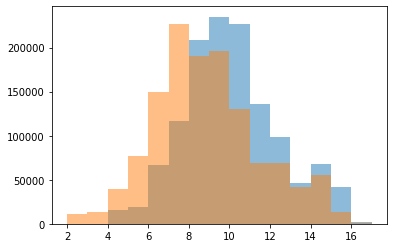

In [16]:
def hist(int_vals, **kwargs):
    a = np.min(int_vals)
    b = np.max(int_vals)
    plt.hist(int_vals, bins=np.arange(a, b+2), **kwargs)

hist(depths[dataset.targets], alpha=0.5)
hist(index_first_ge + 1, alpha=0.5)
plt.show()

In [17]:
%reset -f

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
import torchvision

import datasets
import hier

In [19]:
dataset = torchvision.datasets.ImageNet('/home/jack/data/torchvision/imagenet/', 'train')

In [20]:
with open('resources/hierarchy/imagenet_fiveai.csv') as f:
    tree, node_names = hier.make_hierarchy_from_edges(hier.load_edges(f))

In [21]:
def first(condition, axis=-1):
    assert np.all(np.any(condition, axis=axis))
    return np.argmax(condition, axis=axis)


def hist(int_vals, **kwargs):
    a = np.min(int_vals)
    b = np.max(int_vals)
    plt.hist(int_vals, bins=np.arange(a, b+2), **kwargs)


def degrade_labels(tree, label_nodes, targets, a, b, seed=0):
    node_spec = -np.log(tree.num_leaf_descendants() / tree.num_leaf_nodes())
    paths = tree.paths()

    # Take subset of paths for labels.
    paths = [paths[i] for i in label_nodes]

    # Simplify paths! Remove nodes that have 1 child.
    is_valid = (tree.num_children() != 1)
    if not np.all(is_valid):
        len_before = np.mean(list(map(len, paths)))
        paths = [path[is_valid[path]] for path in paths]
        len_after = np.mean(list(map(len, paths)))
        print('exclude trivial nodes, mean len', len_before, '->', len_after)

    specs = [node_spec[path] for path in paths]
    spec_fracs = [spec / spec[-1] for spec in specs]
    out = np.full([len(paths), max(map(len, paths))], np.nan)
    for i, x in enumerate(spec_fracs):
        out[i, :len(x)] = x
    spec_fracs = out

    rng = np.random.default_rng(seed)
    u = rng.uniform(size=[len(targets)])
    r = scipy.stats.beta.ppf(u, a, b)

    # plt.hist(r, range=(0, 1), bins=100)
    # plt.show()

    depths = np.array(list(map(len, paths)))

    index_first_ge = first(spec_fracs[targets] >= r[:, None])
    coarse = np.asarray([paths[label][index] for label, index in zip(targets, index_first_ge)])

    hist(depths[targets], alpha=0.5)
    hist(index_first_ge + 1, alpha=0.5)
    plt.show()
    
    return coarse

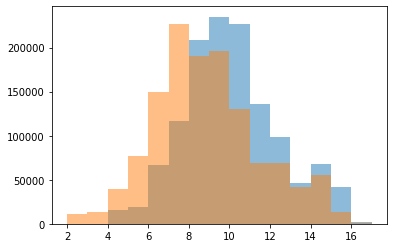

array([  10,   10,    6, ..., 1073, 1281,  309])

In [22]:
degrade_labels(tree, tree.leaf_subset(), dataset.targets, 2, 1)

exclude trivial nodes, mean len 9.0 -> 7.85


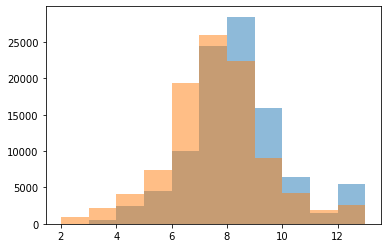

write: resources/override_labels/tiny_imagenet-train-beta-3-1-seed-0.csv.gz
exclude trivial nodes, mean len 9.0 -> 7.85


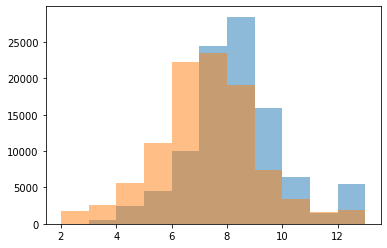

write: resources/override_labels/tiny_imagenet-train-beta-2-1-seed-0.csv.gz
exclude trivial nodes, mean len 9.0 -> 7.85


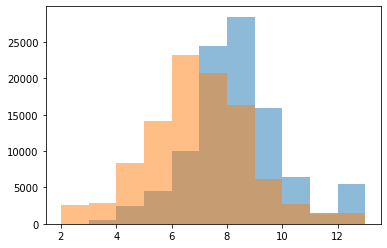

write: resources/override_labels/tiny_imagenet-train-beta-1.5-1-seed-0.csv.gz
exclude trivial nodes, mean len 9.0 -> 7.85


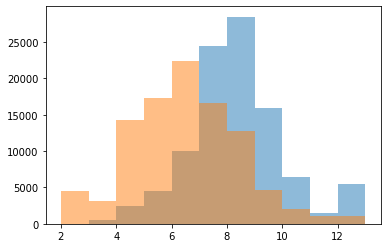

write: resources/override_labels/tiny_imagenet-train-beta-1-1-seed-0.csv.gz
exclude trivial nodes, mean len 9.0 -> 7.85


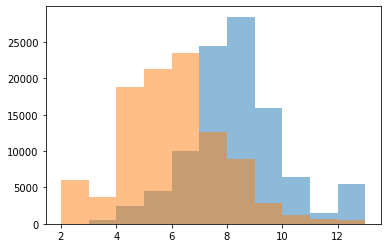

write: resources/override_labels/tiny_imagenet-train-beta-1-1.5-seed-0.csv.gz
exclude trivial nodes, mean len 9.0 -> 7.85


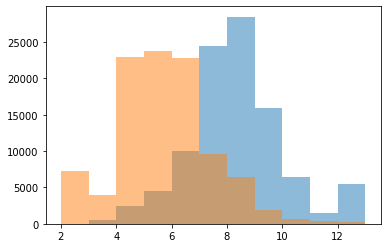

write: resources/override_labels/tiny_imagenet-train-beta-1-2-seed-0.csv.gz


In [29]:
import csv
import gzip
import pathlib

out_dir = pathlib.Path('resources/override_labels')
out_dir.mkdir(parents=True, exist_ok=True)

seed = 0

beta_params = [
    (3, 1),  # Quadratic bias toward leaves.
    (2, 1),  # Linear bias toward leaves.
    (1.5, 1),
    (1, 1),  # Uniform.
    (1, 1.5),
    (1, 2),  # Linear bias toward root.
]

# with open('resources/hierarchy/imagenet_fiveai.csv') as f:
#     tree, node_names = hier.make_hierarchy_from_edges(hier.load_edges(f))
# dataset = torchvision.datasets.ImageNet('/home/jack/data/torchvision/imagenet/', 'train')
# name = 'imagenet-train'

with open('resources/hierarchy/tiny_imagenet_fiveai.csv') as f:
    tree, node_names = hier.make_hierarchy_from_edges(hier.load_edges(f))
dataset = datasets.TinyImageNet('/home/jack/data/manual/tiny_imagenet/', 'train')
name = 'tiny_imagenet-train'

# with open('resources/hierarchy/inat18_anon.csv') as f:
#     tree, node_names = hier.make_hierarchy_from_edges(hier.load_edges(f))
# dataset = datasets.INaturalist2018('/home/jack/data/manual/inaturalist2018/', 'train')
# name = 'inat18-train'

for a, b in beta_params:
    label_order = tree.leaf_subset()
    coarse_targets = degrade_labels(tree, label_order, dataset.targets, a, b, seed=seed)

    fname = out_dir / f'{name}-beta-{a}-{b}-seed-{seed}.csv.gz'
    print('write:', fname)
    with gzip.open(fname, 'wt') as f:
        w = csv.writer(f)
        for i in range(len(dataset)):
            coarse = coarse_targets[i]
            original = label_order[dataset.targets[i]]
            # Write coarse label and original label for sanity check.
            w.writerow((node_names[coarse], node_names[original]))

    # fname = out_dir / f'{name}-beta-{a}-{b}-seed-{seed}.npy'
    # print('write:', fname)
    # np.save(fname, coarse_targets)